# <center>FloPy Regional Model Development</center>
The following script develops a regional MODFLOW model using FloPy and associated packages. The study domain is the Mahomet Aquifer in Illinois, particulary in the heavily irrigated region of Mason County. 

Note that you may not always have to compile MODFLOW, and you only have initialize code (#1) and import large files (#2) the first time you run the code in a session. Most of the time, you will only have to run #3 onward. 

# 0. Compile MODFLOW (DO NOT RUN UNLESS NECESSARY)


When using Google CoLab, you cannot simply use an existing MODFLOW executable, but have to compile a a new one for use in this environment. I have already compiled MODFLOW, but am currently unsure if it will work for everybody. Please do not run the following code unless you get an error that the MODFLOW file was not found (will occur when running the model). 

In [22]:
#!pip install https://github.com/modflowpy/pymake/zipball/master # install of the pymake package to compile MODFLOW

     |████████████████████████████████| 71kB 193kB/s 
  Created wheel for pymake: filename=pymake-1.1.0-cp36-none-any.whl size=38199 sha256=f45a4b02e21b01d1b30ad25f95fef4061299cd3277dd066114c1bfc9daeaf85b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nfy6x4ck/wheels/4e/91/61/e7ad711088661efc2055f76212317884c2ac12bae66f318fdc
Successfully built pymake


In [23]:
# Code to complile the MODFLOW executable

#import pymake

#def make_mf2005():
    #pymake.build_apps('mf2005')


#if __name__ == "__main__":
    #make_mf2005()


mf2005 will be built for the "linux" operating system

mf2005 will be placed in the directory:
    "."

mf2005 will be built using "single" precision floats.

mf2005 will be built as a "release" application.

mf2005 fortran code will be built with "gfortran".
mf2005 c/c++ code will be built with "gcc".

mf2005 will use the following predefined syslibs:
    -lc

mf2005 will be built for "intel64" architecture.

downloading file:         True
verified download:        True
download timeout:         30 sec.
cleaning extracted files: True

extra files are not being read

Attempting to download the file:
    https://water.usgs.gov/water-resources/software/MODFLOW-2005/MF2005.1_12u.zip
 download attempt: 1
   file size: 6,585,179 bytes
     downloaded   204,800 bytes of 6,585,179 bytes (   3.1100%)
     downloaded   409,600 bytes of 6,585,179 bytes (   6.2200%)
     downloaded   614,400 bytes of 6,585,179 bytes (   9.3300%)
     downloaded   819,200 bytes of 6,585,179 bytes (  12.4401%)
    

# 1 Initializing the code


These few code blocks only have to be run at the beginning of the script or if a runtime connection is lost. See details for each below. 

## 1A. Install needed packages
There are three packages that must be installed in the CoLab environment to run this script. These include 

"pyproj", which allows for the conversion from WGS84 coordinates (as obtained from Google Earth), which are in lat/long decimal degrees, to Illimap coordinates, a specialized projection using Lambert Conformal Conic that is optimized for developing a model grid in the state of Illinois. 

"flopy" creates modflow executables, runs the model, and allows for manipulation of results.

"rasterio" allows for the reading of raster files, and is closely tied to the development of "flopy" input files


In [1]:
!pip install pyproj
!pip install flopy
!pip install rasterio

     |████████████████████████████████| 10.4MB 1.3MB/s 
     |████████████████████████████████| 1.1MB 1.4MB/s 
  Created wheel for flopy: filename=flopy-3.3.0-cp36-none-any.whl size=1038572 sha256=2c6ae3759e516871ddc195306bb8041577c2b048d12658fd65e183eee3ba6f30
  Stored in directory: /root/.cache/pip/wheels/d6/af/5a/6d32a03da175b47d8f8cca93b4d363a864cf604164b85af785
Successfully built flopy
     |████████████████████████████████| 18.1MB 250kB/s 


## 1B. Import packages

In [2]:
import flopy # import flopy to develop, run, and analyze the model
from flopy.utils import Raster # plot rasters from flopy
import matplotlib as mp
import pandas as pd
import pyproj # change between WGS84 and Illimap coordinates
import rasterio  # import rasters
import matplotlib.pyplot as plt
import numpy as np 

# the following code authorizes you to access files on Google Drive
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


flopy is installed in /usr/local/lib/python3.6/dist-packages/flopy


## 1C. Authenticate with Google
This will allow you to access shared files on my Google Drive or your own. 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 1D. Read the MODFLOW executable from Google Drive

Here you are going to download the MODFLOW executable from Daniel's Google Drive. This will show up in your temporary working directory for use later in the code. <b>We need to confirm whether this will work in CoLab, or if you need to compile a new version of MODFLOW each time.</b>

Note that this makes use of a key on your Google Drive sharable link for the file. This generally takes the form of: https://drive.google.com/file/d/**key**/view?usp=sharing, in this case, key = 1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V

In [0]:
downloaded = drive.CreateFile({'id':"1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V"}) # This is the key that is defined in the sharable link of a file on Google Drive
downloaded.GetContentFile('mf2005') # get the content from Google Drive and name it (let's stick with mf2005 here)

Now we need to copy the executable into a location where we can later run it. Note that the "!" nomenclature is a shell command, beyond the scope of this course to learn that!

In [0]:
!cp mf2005 /usr/local/bin
!chmod 755 /usr/local/bin/mf2005

# 2 Import the big stuff


We don't want to repeatedly import large files for fear of Google revoking our CoLab priveleges for a few hours. Once or twice isn't a big deal, but repeatedly might be an issue. Let Daniel know if this happens- there are ways to reduce our file sizes. 

For now, the "big stuff" includes a DEM of Illinois and the river excel file we worked with last time. 

## 2A. Import the DEM

In [0]:
# first import the .tif from Google Drive
downloaded = drive.CreateFile({'id':"1U35QAOqW0R9IPxrh6EtO6Cmm5VO4qezq"})   
downloaded.GetContentFile('dem_ill.tif')

## 2B. Import the river file

In [0]:
# first import the Excel file from Google Drive
downloaded = drive.CreateFile({'id':"1JsAiGG4RvcfYrQtfgXRW9ZVfAkQ1yRVu"})
downloaded.GetContentFile('rivers_625.csv')

# 3 Create MODFLOW  packages

## 3A. Create the MODFLOW model object 

In [0]:
# Create a MODFLOW model object and run with MODFLOW 2005.

modelname = "my_model" # name the model
m = flopy.modflow.Modflow(modelname, exe_name = 'mf2005') # create model object m

## 3B. Discretization Package

### 3Bi. Define the Model Domain

In [0]:
#----------------------------------------------------------------------------
# Define model domain in lat/long coordinates
sw_lat =  40.045872 #southwest latitude
sw_long = -90.397402 #southwest longitude
ne_lat =  40.575944 #northeast latitude
ne_long = -89.587339 #northeast longitude

illimap = {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66',
     'lon_0': -89.5,
     'lat_0': 33,
     'lat_1': 33,
     'lat_2': 45,
     'x_0': 2999994*0.3048,
     'y_0': 0}

prj = pyproj.Proj(illimap)

wgs84 = pyproj.Proj("epsg:4326")

nex, ney = pyproj.transform(wgs84,illimap,ne_lat,ne_long)
swx, swy = pyproj.transform(wgs84,illimap,sw_lat,sw_long)


nex, ney = round(nex/0.3048,-4), round(ney/0.3048,-4)
swx, swy = round(swx/0.3048,-4), round(swy/0.3048,-4)

### 3Bii. Define other discretization variables (grid and stress periods)

In [0]:
# Assign Discretization variables
Lx = nex-swx # Width of the model domain
Ly = ney-swy # Height of the model domain
zbot = -50. # Model bottom elevation
nlay = 1 # Number of model layers
dx = 1000
dy = 1000
nrow = int(Ly/dy) # Number of rows
ncol = int(Lx/dx) # Number of columns

nper = 1 #specify number of stress periods
steady = [True] #specify if stress period is transient or steady-state


### 3Biii. Define the top and bottom elevation



In [0]:
# Now load the raster using FloPy's built in Raster toolbox
illinoisdem = Raster.load("dem_ill.tif")

# Crop the dEM to the model domain
illinoisdem.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)])
# Define centroid of the southwestern most cell
startx = swx+dx/2 
starty = swy+dx/2
# Calculate the x and y coordinates for the centroid of each cell 
xc = np.arange(swx+dx/2,nex+dx/2,dx) 
yc = np.arange(swy+dy/2,ney+dy/2,dy)
# Create a grid of the x coordinate of each centroid and the y coordinate
xarr, yarr = np.meshgrid(xc,yc)
# resample the topo raster to the grid of centroids of the model
topgrid = illinoisdem.resample_to_grid(xarr,yarr,1,method='nearest') 
# We just built our top elevation upside down, let's flip it
topgrid = np.flipud(3.28*topgrid) # elevations were in meters above mean sea level, we want feet.

### 3Biv. Append the discretization package to the model object

In [0]:
# length and time are feet (1) and days (4).
# See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=topgrid, botm=zbot, 
                               itmuni = 4, lenuni = 1, 
                               nper=nper, steady=steady)

## 3C. Basic Package

In [0]:

# Create ibound as array of ints (1), indicating all cells are active
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

# Create starting head array, must be floats.
strt = 400*np.ones((nlay, nrow, ncol), dtype=np.float32) #set every cell to 5.0

#Create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)


## 3D. LPF Package

In [0]:
'''Create the Layer Property Flow Package, which contains information about
hydruaulic conductivity and other information about how to calculate flow'''

hk = 250*np.ones((nlay,nrow,ncol), dtype=np.float32) #define horizontal hydraulic conductivity
vk = np.ones((nlay,nrow,ncol), dtype=np.float32) #define vertical hydraulic conductivity

#define layer type as convertible (1), must be an integer
#for more information, see https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm
laytyp = np.ones((nlay,), dtype=np.int32)

# create the LPF object
lpf = flopy.modflow.ModflowLpf(model=m, hk=hk, vka=vk, laytyp=laytyp, ipakcb=1)


## 3E. Boundary Conditions

### 3Ei. Recharge Package

In [0]:
# assign recharge to the model
rch = flopy.modflow.mfrch.ModflowRch(model=m,rech = 0.001) # recharge rate is uniform and in ft/day


### 3Eii. River Package

In [0]:
# import stage, lambert x, lambert y
dfriv = pd.read_csv('rivers_625.csv')

# trim dataframe with river information to the model domain
dfriv = dfriv.loc[dfriv['lamx']<nex]
dfriv = dfriv.loc[dfriv['lamy']<ney]
dfriv = dfriv.loc[dfriv['lamx']>swx]
dfriv = dfriv.loc[dfriv['lamy']>swy]

# assign all rivers to the upper layer
dfriv['lay'] = 0
# convert lamx to column and lamy to row
dfriv['row'] = np.trunc((ney-dfriv['lamy'])/dy)
dfriv['col'] = np.trunc((dfriv['lamx']-swx)/dx)
# define the river stage
dfriv['stage'] = dfriv['rvr_stg']
#define the conductance
dfriv['cond'] = 5000. # ft^2/d
# define the river bottom
dfriv['bot'] = dfriv['stage']-3
# drop unneeded files
dfriv = dfriv.drop(['STR_ORD_MI','STR_ORD_MA','SUM_LENGTH','rvr_stg','lamx','lamy'],axis=1)

# put into a format that MODFLOW wants
arriv = dfriv.values
riverdata = {0: arriv}

# create river package
riv = flopy.modflow.mfriv.ModflowRiv(model=m, ipakcb=None,stress_period_data=riverdata)


## 3F. Define output control

In [0]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
#create output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 3G. Solver

In [0]:
# We will start by using the PCG solver with default settings
pcg = flopy.modflow.ModflowPcg(model=m)

## 3H. Plot model inputs (boundary conditions, elevations)

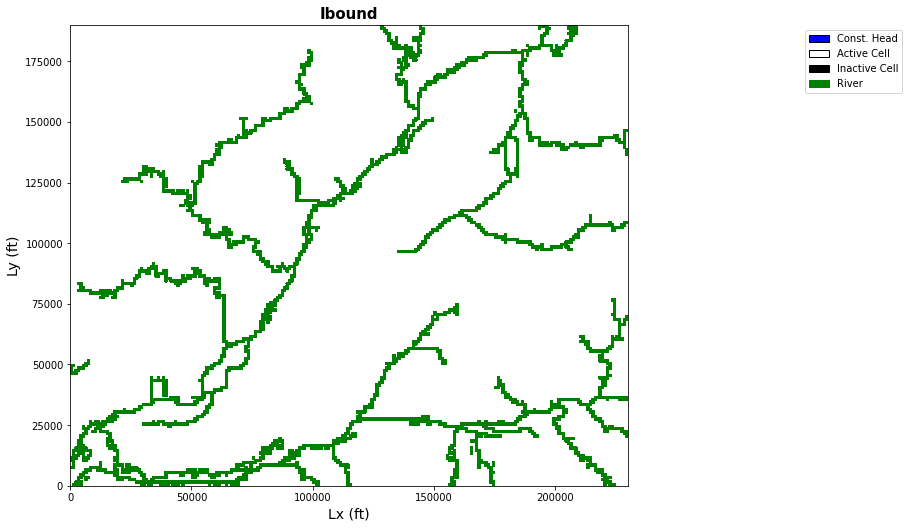

In [19]:
'''Plot grid and boundary conditions'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
#grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
rvr = modelmap.plot_bc(ftype='RIV')
#add labels and legend
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='green',label='River',ec='green')],
                   bbox_to_anchor=(1.5,1.0))
#----------------------------------------------------------------------------

Text(0.5, 1.0, 'Top Elevation (ft AMSL)')

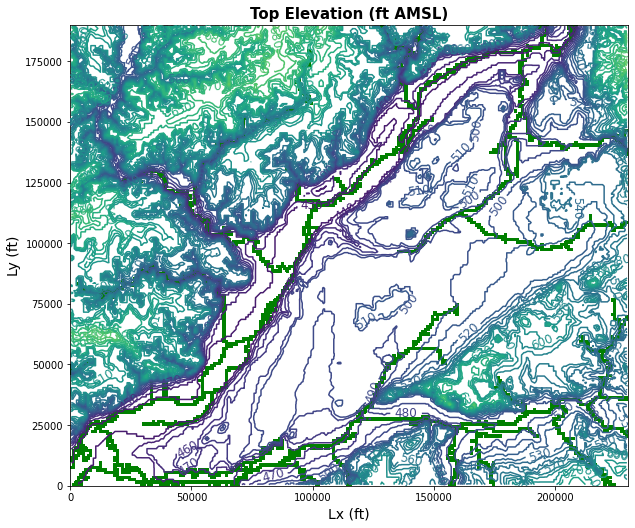

In [20]:
'''Plot elevation'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
contour_levels = np.linspace(400,800,41)
topelevations = modelmap.contour_array(topgrid, levels = contour_levels) #create head contours
plt.clabel(topelevations, inline=True,fontsize=12,fmt='%1.0f')
rvr = modelmap.plot_bc(ftype='RIV')

#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Top Elevation (ft AMSL)', fontsize = 15, fontweight = 'bold')

# 4 Write and run the MODFLOW model

In [21]:
# Write the model input
m.write_input()
# Execute the model run
success, mfoutput = m.run_model(pause=False, report=True)
# Report back if the model did not successfully complete
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/04/08 21:48:00

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/08 21:48:02
 Elapsed run time:  2.417 Seconds

 FAILED TO MEET SOLVER CONVERGENCE CRITERIA            1  TIME(S)


Exception: ignored

# 5 Plot Output Data

In [0]:
'''Extract binary data from head and flow files'''
#----------------------------------------------------------------------------
#extract binary data from head file as flopy head object
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
#extract head data from head object
head = headobj.get_data(totim=1.0)

#extract binary data from budget file as flopy budget object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
#extract flow data from budget object, define face over which flow is reported
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)

Text(0.5, 1.0, 'Steady-State Model, Flow(ft^3/d) and Head(ft) Results')

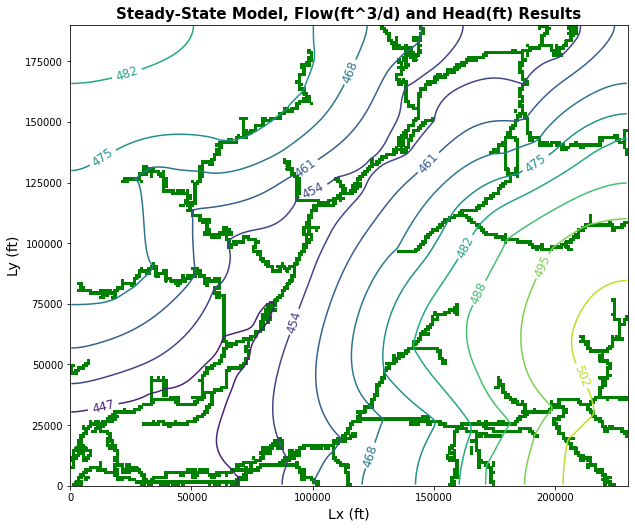

In [25]:
'''Plot results'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
#contour_levels = np.linspace(400,650,26) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours
plt.clabel(head_contours, inline=True,fontsize=12,fmt='%1.0f')
#flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows
rvr = modelmap.plot_bc(ftype='RIV')

#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Steady-State Model, Flow(ft^3/d) and Head(ft) Results', fontsize = 15, fontweight = 'bold')